In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")


In [2]:
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint

In [3]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

## Run a session of the SCML world (2020)

The SCML world (Supply Chain Management League) runs on top of `NegMAS`.

In this tutorial, you will test a run of this world.

Firstly, let's import everything from the SCML app

In [4]:
from scml.scml2020 import *

There are several ways to create an SCML world. One of the simplest is to use the `generate` method of the `SCML2020World` class. This will create a dict that can be passed to the `SCML2020World` constructor as keyword arguments. 

Here we explicitly set `construct_graphs` to True which slows the simulation yet allows us to see graph representations of what is happening in the world. 


In [5]:
agent_types = [DecentralizingAgent, BuyCheapSellExpensiveAgent, 
               IndDecentralizingAgent, MovingRangeAgent]

In [6]:
world = SCML2020World(
    **SCML2020World.generate(
        agent_types=agent_types,
        n_steps=50
    ), 
    construct_graphs=True,
)

Let's draw a graph to see what is in this world

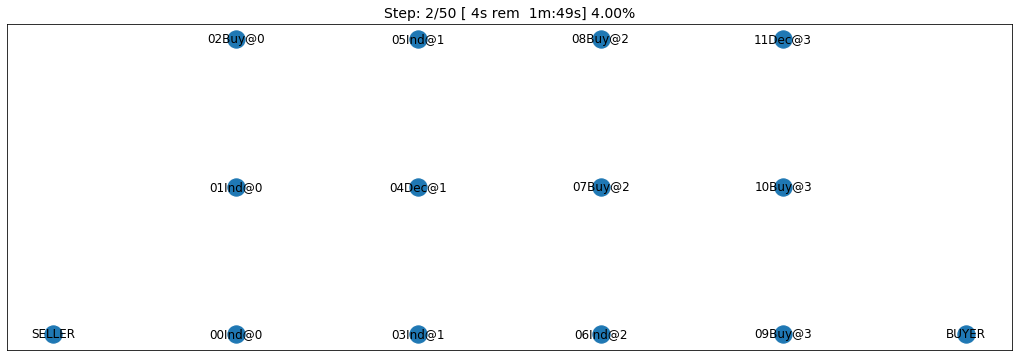

In [7]:
_, _ = world.draw()

*If you want to just test your installation (and do not care whether you get an accurate indicator of agent performance), you can set the number of steps to a small value (e.g. n_steps=10).*

Now you can run this world simulation by just calling `run`. 

In [8]:
world.run_with_progress() # may take few minutes

100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


Let's see what happened in this run. Firstly, how many negotiations were conducted over time

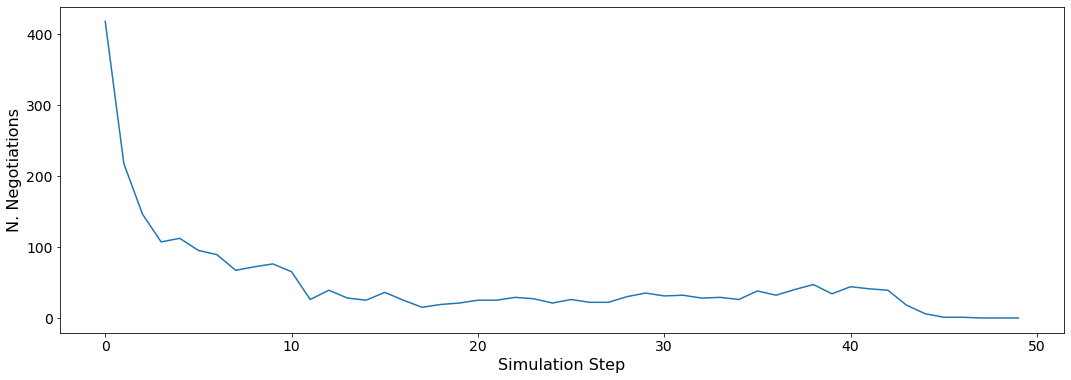

In [9]:
plt.plot(world.stats['n_negotiations'])
plt.xlabel('Simulation Step')
plt.ylabel('N. Negotiations')
plt.show()

It is clear that many negotiations happened at the beginning of the simulation with smaller number later. That is expected as the agents at the first and last production layer receive more exogenous contracts in the beginning.

Several other market statistics are available:

In [10]:
pprint(list(_ for _ in world.stats.keys() if "@" not in _  ))

['n_registered_negotiations_before',
 'n_contracts_dropped',
 'n_contracts_nullified_now',
 'n_bankrupt',
 'trading_price_0',
 'sold_quantity_0',
 'unit_price_0',
 'trading_price_1',
 'sold_quantity_1',
 'unit_price_1',
 'trading_price_2',
 'sold_quantity_2',
 'unit_price_2',
 'trading_price_3',
 'sold_quantity_3',
 'unit_price_3',
 'trading_price_4',
 'sold_quantity_4',
 'unit_price_4',
 'productivity',
 'market_size',
 'production_failures',
 'bankruptcy',
 'n_contracts_executed',
 'n_contracts_erred',
 'n_contracts_nullified',
 'n_contracts_cancelled',
 'n_breaches',
 'breach_level',
 'n_contracts_signed',
 'n_contracts_concluded',
 'n_negotiations',
 'n_negotiation_rounds_successful',
 'n_negotiation_rounds_failed',
 'n_negotiation_successful',
 'n_negotiation_failed',
 'n_registered_negotiations_after',
 'activity_level',
 'step_time',
 'total_time']


Let's start by seeing how long did each step take (note that `stats` access the stats as a Dict[str, List] but `stats_df` access the same data as a pandas dataframe.

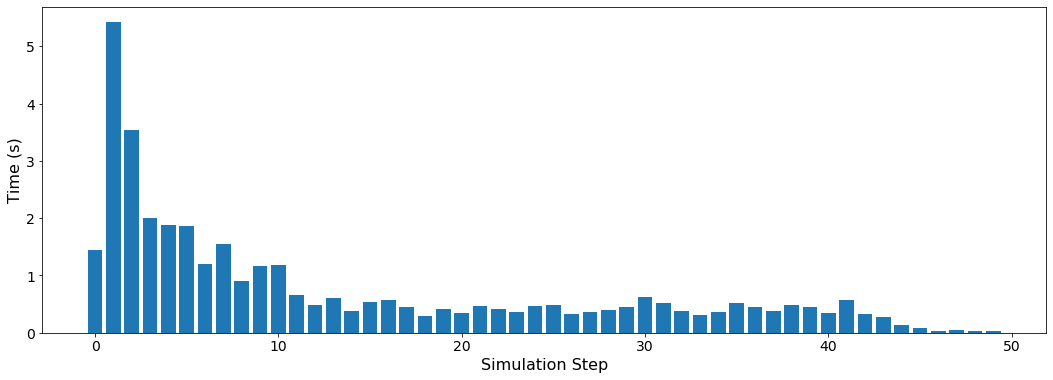

In [11]:
plt.bar(range(world.n_steps), world.stats_df['step_time'])
plt.xlabel('Simulation Step')
plt.ylabel('Time (s)')
plt.show()

There are statistics specific for each agent that all have "_{agent_name}". Lets check what is available for the winner agent:

In [12]:
winner = world.winners[0]
pprint(list(_ for _ in world.stats.keys() if winner.name in _ ))

['spot_market_quantity_01Ind@0',
 'spot_market_loss_01Ind@0',
 'balance_01Ind@0',
 'inventory_01Ind@0_input',
 'inventory_01Ind@0_output',
 'productivity_01Ind@0',
 'assets_01Ind@0',
 'bankrupt_01Ind@0',
 'score_01Ind@0']


The convension is that agent names has the form {ind}{Type}{process} where **ind** is a unique index, **Type** is a shortened version of the agent's type name, and **process** is the process the agnet can run. Note that the agent's input product has the same number as its process and its output product has the next number (i.e. an agent that runs process 1, has input product 1 and output product 2).

We can see that 8 pieces of information are available (for each time-step of the simulation):

- **bankrupt** If true, the agent is bankrupt.
- **balance** The money the agent has in its wallet (account).
- **inventory (input)** The number of units of the agent's input product available in its inventory (by the end of the simulation step).
- **inventory (output)** The number of units of the agent's output product available in its inventory (by the end of the simulation step).
- **assets** The value of the agent's assets (input and output products in inventory) evaluated at the trading price
- **spot market quantity** The quantity bought by this agent from the spot market (of its output product on this step). This can only happen as a result of a product-breach.
- **spot market loss** The spot market price for the agent. This value will go up the more the agent buys from the spot market and will be used to calculate the price for this agent at future steps. This way agents that depend on the spot market instead of negotiation get punished.
- **productivity** The fraction of the agent's production lines that were active at a given time-step.
- **score** The score of the agent according to the evaluation rule of ANAC SCML 2020

Let's see how did our agent do

In [13]:
#show the first and last value of each of the agent statistics
pprint({k:(v[0], v[-1]) for k, v in world.stats.items() if winner.name in k })

{'assets_01Ind@0': (150.0, 45.181448602429796),
 'balance_01Ind@0': (8771, 11520),
 'bankrupt_01Ind@0': (False, False),
 'inventory_01Ind@0_input': (1, 0),
 'inventory_01Ind@0_output': (10, 3),
 'productivity_01Ind@0': (1.0, 0.0),
 'score_01Ind@0': (-0.003940997635401419, 0.2996949357393554),
 'spot_market_loss_01Ind@0': (0.3, 2.7299999999999995),
 'spot_market_quantity_01Ind@0': (0, 0)}


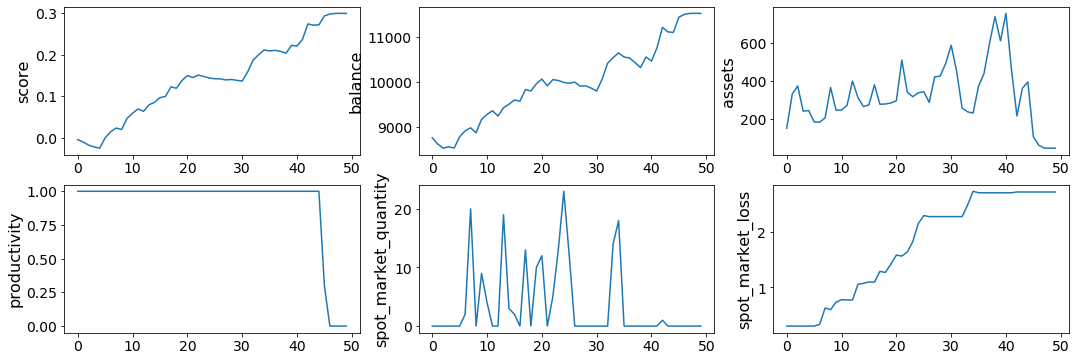

In [14]:
stats = pd.DataFrame(data=world.stats)
fig, axs = plt.subplots(2, 3)
for ax, key in zip(axs.flatten().tolist(), ["score", "balance", "assets", "productivity", 
                         "spot_market_quantity", "spot_market_loss"]):
    ax.plot(stats[f"{key}_{winner}"])
    ax.set(ylabel=key)
fig.show()

We can for example check the activity level of this world (defined as the total amount of money transferred due to trade)

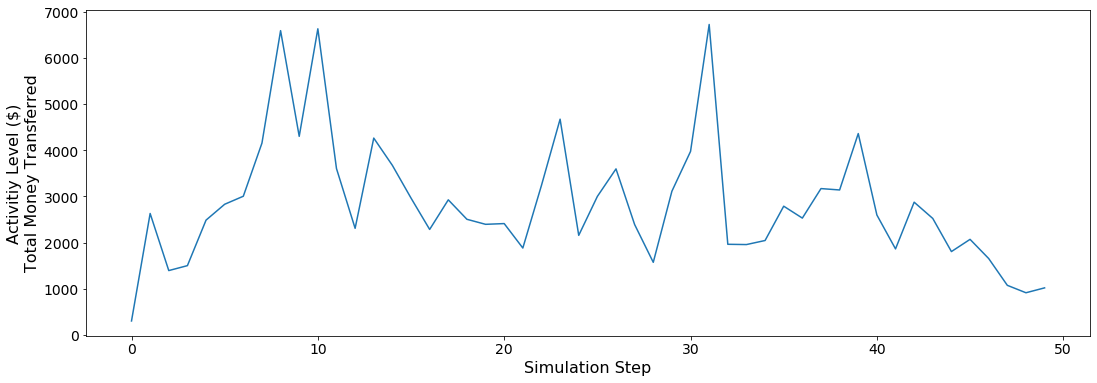

In [15]:
plt.plot(world.stats['activity_level'])
plt.xlabel('Simulation Step')
plt.ylabel('Activitiy Level ($)\nTotal Money Transferred')
plt.show()

We can see a picture of contracting in this world as follows:

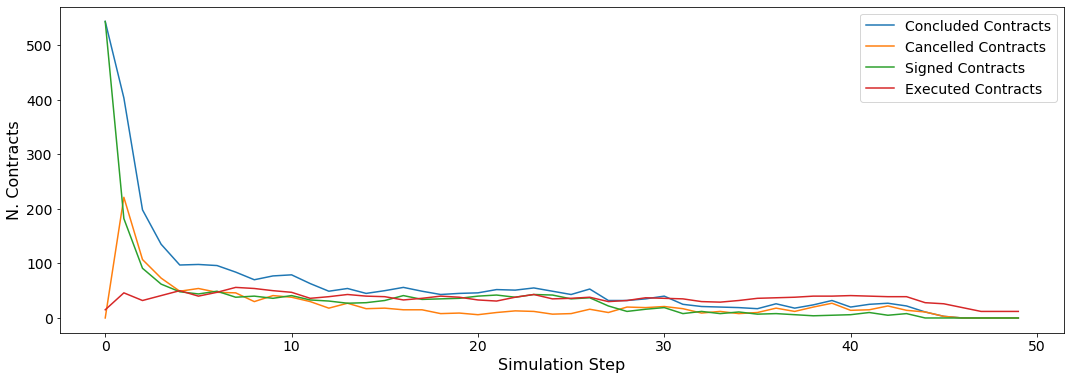

In [16]:
plt.plot(world.stats['n_contracts_concluded'], label='Concluded Contracts')
plt.plot(world.stats['n_contracts_cancelled'], label='Cancelled Contracts') 
plt.plot(world.stats['n_contracts_signed'], label='Signed Contracts') 
plt.plot(world.stats['n_contracts_executed'], label='Executed Contracts')
plt.legend()
plt.xlabel('Simulation Step')
plt.ylabel('N. Contracts')
plt.show()

We can also check the breaches that happened

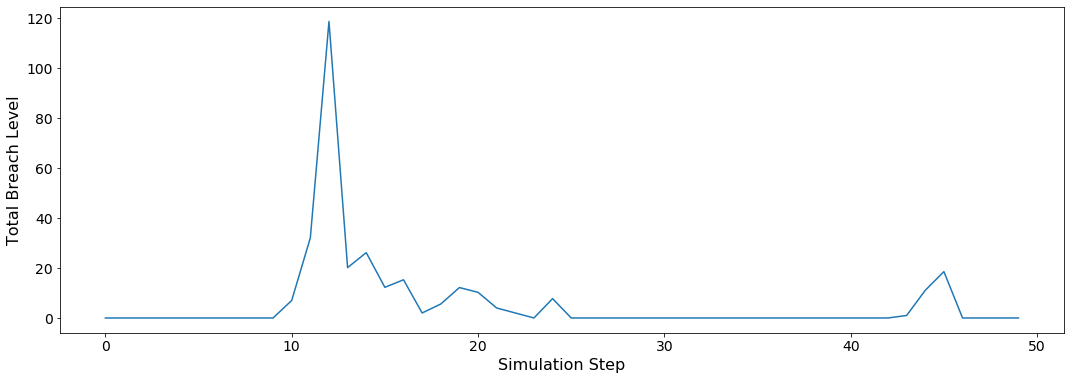

In [17]:
plt.plot(world.stats['breach_level'])
plt.xlabel('Simulation Step')
plt.ylabel('Total Breach Level')
plt.show()

Notice that there can be multiple winners

In [18]:
winner_profits = [100 * world.scores()[_.id] for _ in world.winners]
winner_types = [_.short_type_name for _ in world.winners]
print(f"{world.winners} of type {winner_types} won at {winner_profits}%")

[01Ind@0] of type ['ind_decentralizing'] won at [29.96949357393554]%


Let's check how did the first winner's inventory changes over time:

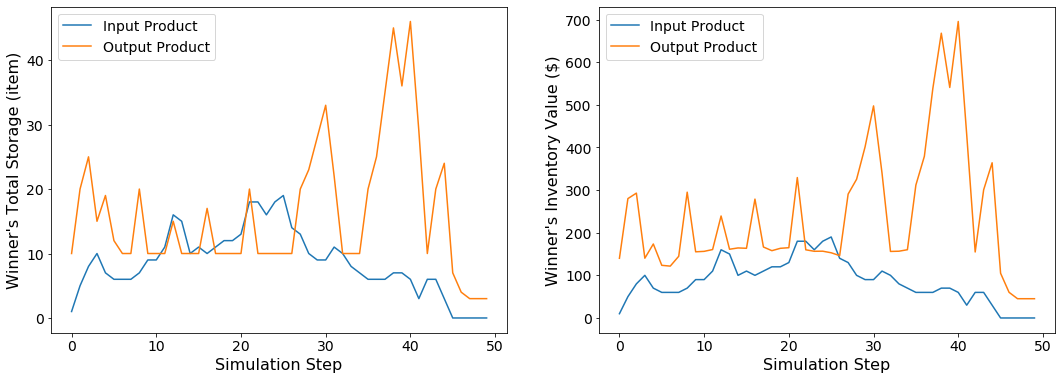

In [19]:
# find the keys in stats for the input and output inventory
in_key = [_ for _ in world.stats.keys() if _.startswith(f'inventory_{winner}_input')][0]
out_key = [_ for _ in world.stats.keys() if _.startswith(f'inventory_{winner}_output')][0]

# find input and output product indices
input_product, output_product = winner.awi.my_input_product, winner.awi.my_output_product
# draw
fig, (quantity, value) = plt.subplots(1, 2)
quantity.plot(world.stats[in_key], label=f"Input Product")
quantity.plot(world.stats[out_key], label=f"Output Product")
quantity.set(xlabel='Simulation Step', ylabel='Winner\'s Total Storage (item)')
quantity.legend()
value.plot(np.array(world.stats[in_key]) * np.array(world.stats[f"trading_price_{input_product}"])
              , label=f"Input Product")
value.plot(np.array(world.stats[out_key]) * np.array(world.stats[f"trading_price_{output_product}"])
              , label=f"Output Product")
value.set(xlabel='Simulation Step', ylabel='Winner\'s Inventory Value ($)')
value.legend()
fig.show()

We can actually check what happens to ALL competitors:

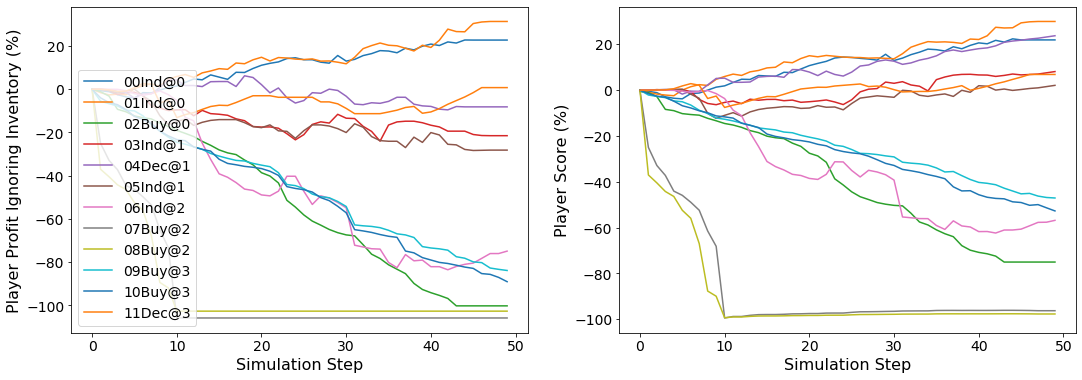

In [20]:
from scml.scml2020.world import is_system_agent
fig, (profit, score) = plt.subplots(1, 2)
snames = sorted(world.non_system_agent_names)
for name in snames:    
    profit.plot(100.0 * (np.asarray(world.stats[f'balance_{name}'])/world.stats[f'balance_{name}'][0] - 1.0), label=name)
    score.plot(100 * np.asarray(world.stats[f'score_{name}']), label=name)
profit.set(xlabel='Simulation Step', ylabel='Player Profit Ignoring Inventory (%)')
profit.legend(loc='lower left')
score.set(xlabel='Simulation Step', ylabel='Player Score (%)')
fig.show()

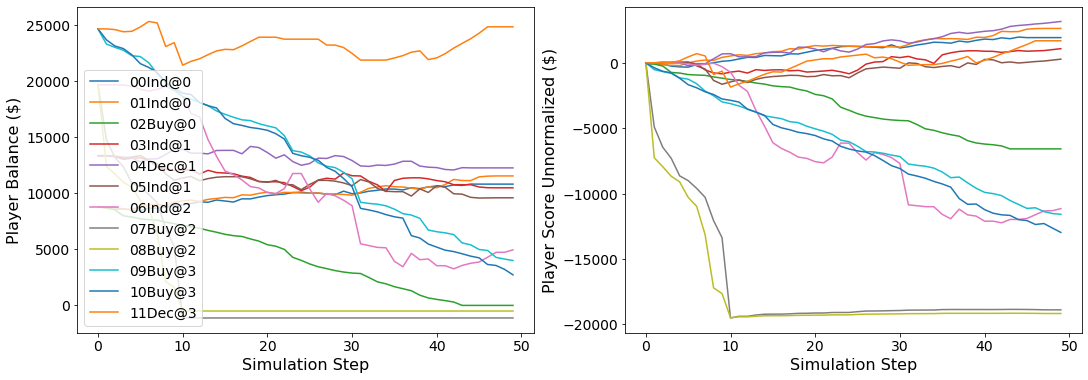

In [21]:
from scml.scml2020.world import is_system_agent
fig, (profit, score) = plt.subplots(1, 2)
snames = sorted(world.non_system_agent_names)
for name in snames:    
    profit.plot((np.asarray(world.stats[f'balance_{name}'])), label=name)
    score.plot(np.asarray(world.stats[f'score_{name}'])*(world.stats[f'balance_{name}'][0]), label=name)
profit.set(xlabel='Simulation Step', ylabel='Player Balance ($)')
profit.legend(loc='lower left')
score.set(xlabel='Simulation Step', ylabel='Player Score Unnormalized ($)')
fig.show()

or just look at the end of the game

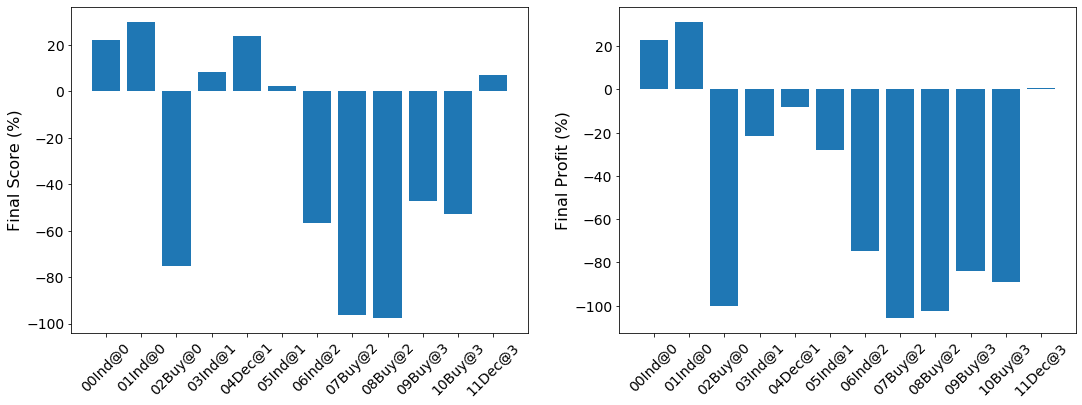

In [22]:
fig, (score, profit) = plt.subplots(1, 2)
final_scores = [100 * world.stats[f"score_{_}"][-1] 
                for _ in world.non_system_agent_names]
final_profits = [100 * world.stats[f"balance_{_}"][-1] / world.stats[f"balance_{_}"][0] - 100 
                 for _ in world.non_system_agent_names]
plt.setp(score.xaxis.get_majorticklabels(), rotation=45)
plt.setp(profit.xaxis.get_majorticklabels(), rotation=45)
score.bar(world.non_system_agent_names, final_scores)
profit.bar(world.non_system_agent_names, final_profits)
score.set(ylabel="Final Score (%)")
profit.set(ylabel="Final Profit (%)")

fig.show()

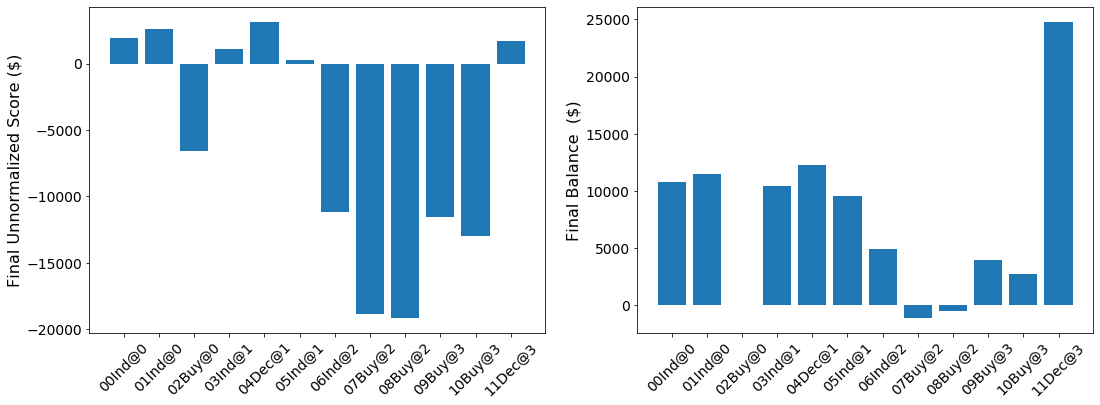

In [23]:
fig, (score, profit) = plt.subplots(1, 2)
final_scores = [world.stats[f"score_{_}"][-1] * (world.stats[f"balance_{_}"][0]) 
                for _ in world.non_system_agent_names]
final_profits = [world.stats[f"balance_{_}"][-1] 
                 for _ in world.non_system_agent_names]
plt.setp(score.xaxis.get_majorticklabels(), rotation=45)
plt.setp(profit.xaxis.get_majorticklabels(), rotation=45)
score.bar(world.non_system_agent_names, final_scores)
profit.bar(world.non_system_agent_names, final_profits)
score.set(ylabel="Final Unnormalized Score ($)")
profit.set(ylabel="Final Balance  ($)")

fig.show()

You can inspect what happened in the simulation by plotting different output statistics. For example, we can see how did the trading price of different products change over the simulation time.

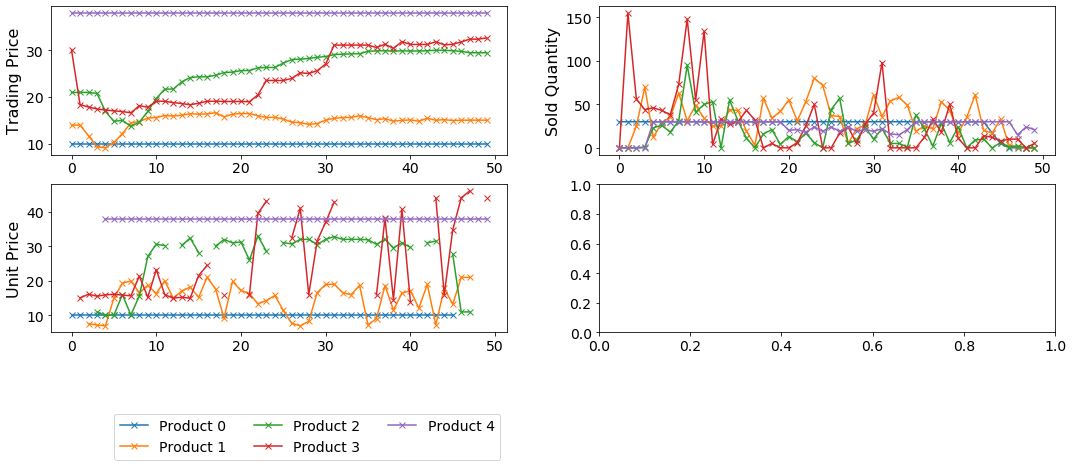

In [24]:
fig, axs = plt.subplots(2, 2)
for ax, key in zip(axs.flatten().tolist(), ["trading_price", "sold_quantity", "unit_price"]):
    for p in range(world.n_products):
        ax.plot(world.stats[f"{key}_{p}"], marker="x", label=f"Product {p}")
        ax.set_ylabel(key.replace("_", " ").title())
        ax.legend().set_visible(False)
axs[-1, 0].legend(bbox_to_anchor=(1, -.5), ncol=3)
fig.show()

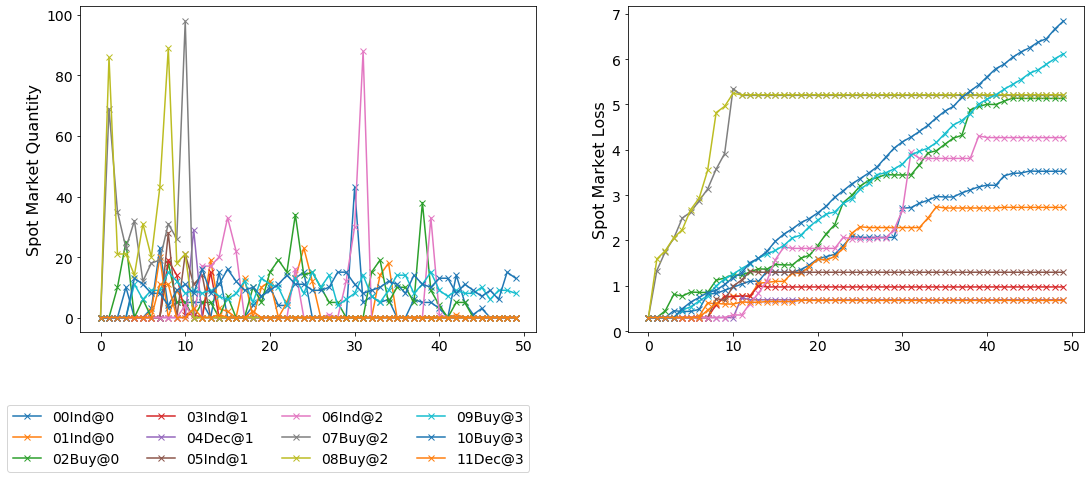

In [25]:
fig, axs = plt.subplots(1, 2)
for ax, key in zip(axs.flatten().tolist(), ["spot_market_quantity", "spot_market_loss"]):
    for a in world.non_system_agent_names:
        ax.plot(world.stats[f"{key}_{a}"], marker="x", label=f"{a}")
        ax.set_ylabel(key.replace("_", " ").title())
        ax.legend().set_visible(False)
axs[0].legend(bbox_to_anchor=(1, -.2), ncol=4)
fig.show()

You can dig futher to understand what happened during this siumulation. For example, let's see some of the contracts that were signed:

In [26]:
# create a view with only signed contracts
contracts = world.contracts_df
signed = contracts.loc[contracts.signed_at>=0, :]

In [27]:
fields = ["seller_name", "buyer_name", "delivery_time", "quantity", "unit_price",
          "signed_at", "executed", "breached", "nullified", "erred"]
signed[fields].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,executed,breached,nullified,erred
1001,07Buy@2,11Dec@3,10,71,30,2,True,False,False,False
1024,08Buy@2,11Dec@3,11,68,30,2,False,True,False,False
1305,08Buy@2,11Dec@3,13,65,30,4,False,True,False,False
958,08Buy@2,11Dec@3,8,63,30,2,True,False,False,False
1290,07Buy@2,11Dec@3,14,62,30,4,False,True,False,False
2414,06Ind@2,10Buy@3,31,39,46,21,True,False,False,False
2418,06Ind@2,09Buy@3,31,39,46,21,True,False,False,False
2636,03Ind@1,06Ind@2,35,33,32,26,True,False,False,False
2722,02Buy@0,04Dec@1,38,33,14,28,True,False,False,False
2697,06Ind@2,10Buy@3,37,27,43,27,True,False,False,False


Let's check some of the contracts that were fully executed

In [28]:
signed.loc[signed.executed, fields].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,executed,breached,nullified,erred
1001,07Buy@2,11Dec@3,10,71,30,2,True,False,False,False
958,08Buy@2,11Dec@3,8,63,30,2,True,False,False,False
2414,06Ind@2,10Buy@3,31,39,46,21,True,False,False,False
2418,06Ind@2,09Buy@3,31,39,46,21,True,False,False,False
2636,03Ind@1,06Ind@2,35,33,32,26,True,False,False,False
2722,02Buy@0,04Dec@1,38,33,14,28,True,False,False,False
2697,06Ind@2,10Buy@3,37,27,43,27,True,False,False,False
2053,06Ind@2,10Buy@3,23,25,43,14,True,False,False,False
2063,06Ind@2,09Buy@3,23,25,43,14,True,False,False,False
1003,05Ind@1,06Ind@2,13,24,30,2,True,False,False,False


In [29]:
signed.loc[signed.breached, fields[:-4] + ["breaches"]].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,breaches
1024,08Buy@2,11Dec@3,11,68,30,2,08Buy@2:product(1.0)
1305,08Buy@2,11Dec@3,13,65,30,4,08Buy@2:product(1.0)
1290,07Buy@2,11Dec@3,14,62,30,4,07Buy@2:product(1.0)
946,05Ind@1,07Buy@2,12,24,30,2,07Buy@2:money(2.5779257067718606)
951,05Ind@1,08Buy@2,12,24,30,2,08Buy@2:money(1.7168310322156477)
999,05Ind@1,08Buy@2,11,21,30,2,08Buy@2:money(1.8192354653893117)
1188,04Dec@1,07Buy@2,11,21,30,3,07Buy@2:money(2.803343664882126)
970,03Ind@1,08Buy@2,16,19,33,2,08Buy@2:money(1.82315525230505)
1002,03Ind@1,07Buy@2,21,19,30,2,07Buy@2:money(2.993169313817087)
1724,08Buy@2,10Buy@3,13,15,14,9,08Buy@2:product(1.0)


We can now see how does the singning day affect delivery day, product and quantity

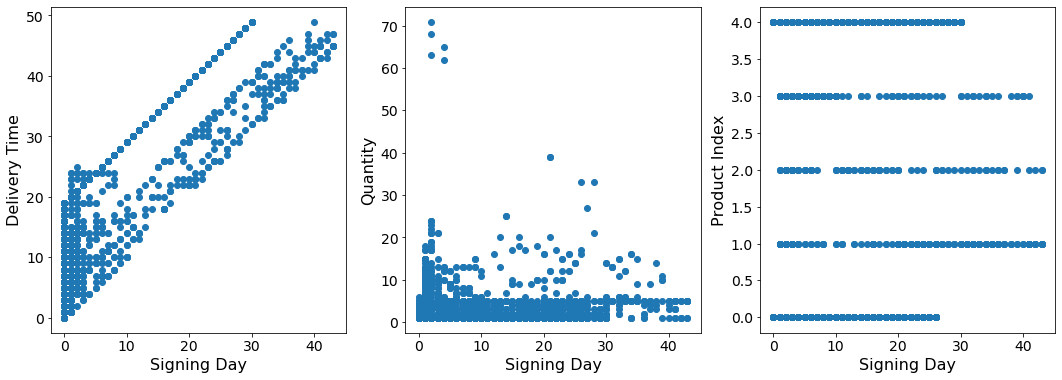

In [30]:
fig, ax = plt.subplots(1, 3)
for i, x in enumerate(["delivery_time", "quantity", "product_index"]):
    ax[i].scatter(signed.signed_at, signed[x])
    ax[i].set(ylabel=x.replace("_", " ").title(), xlabel="Signing Day")
fig.show()

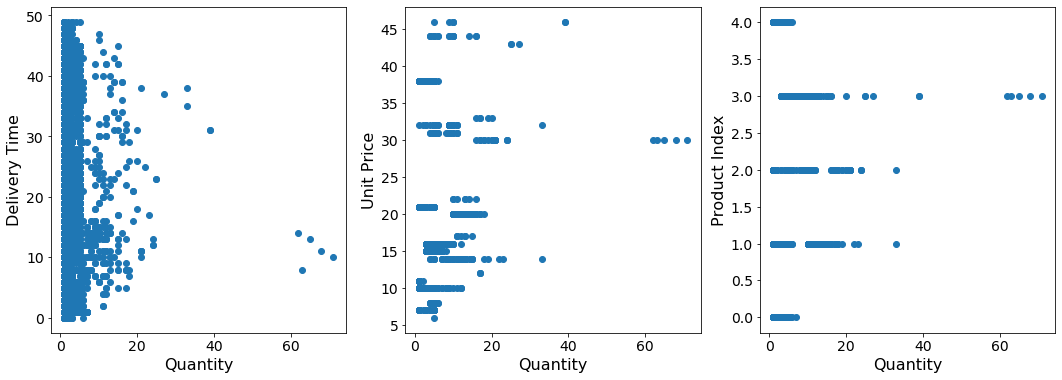

In [31]:
fig, ax = plt.subplots(1, 3)
for i, x in enumerate(["delivery_time", "unit_price", "product_index"]):
    ax[i].scatter(signed.quantity, signed[x])
    ax[i].set(ylabel=x.replace("_", " ").title(), xlabel="Quantity")
fig.show()

Did any agents go bankrupt and when?

In [32]:
bankruptcy = {a: np.nonzero(stats[f"bankrupt_{a}"].values)[0]
        for a in world.non_system_agent_names}
pprint({k: "No" if len(v)<1 else f"at: {v[0]}" for k, v in bankruptcy.items()})

{'00Ind@0': 'No',
 '01Ind@0': 'No',
 '02Buy@0': 'at: 43',
 '03Ind@1': 'No',
 '04Dec@1': 'No',
 '05Ind@1': 'No',
 '06Ind@2': 'No',
 '07Buy@2': 'at: 10',
 '08Buy@2': 'at: 10',
 '09Buy@3': 'No',
 '10Buy@3': 'No',
 '11Dec@3': 'No'}


You can see what happened during this simulation by drawing graphs at different steps.
The meaning of different edge colors can be drawn as follows:

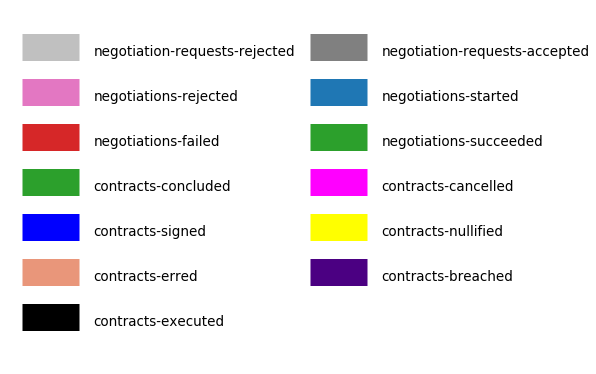

In [33]:
from negmas import show_edge_colors
show_edge_colors()

You can see what happened in this world in a series of graphs using the `draw` method

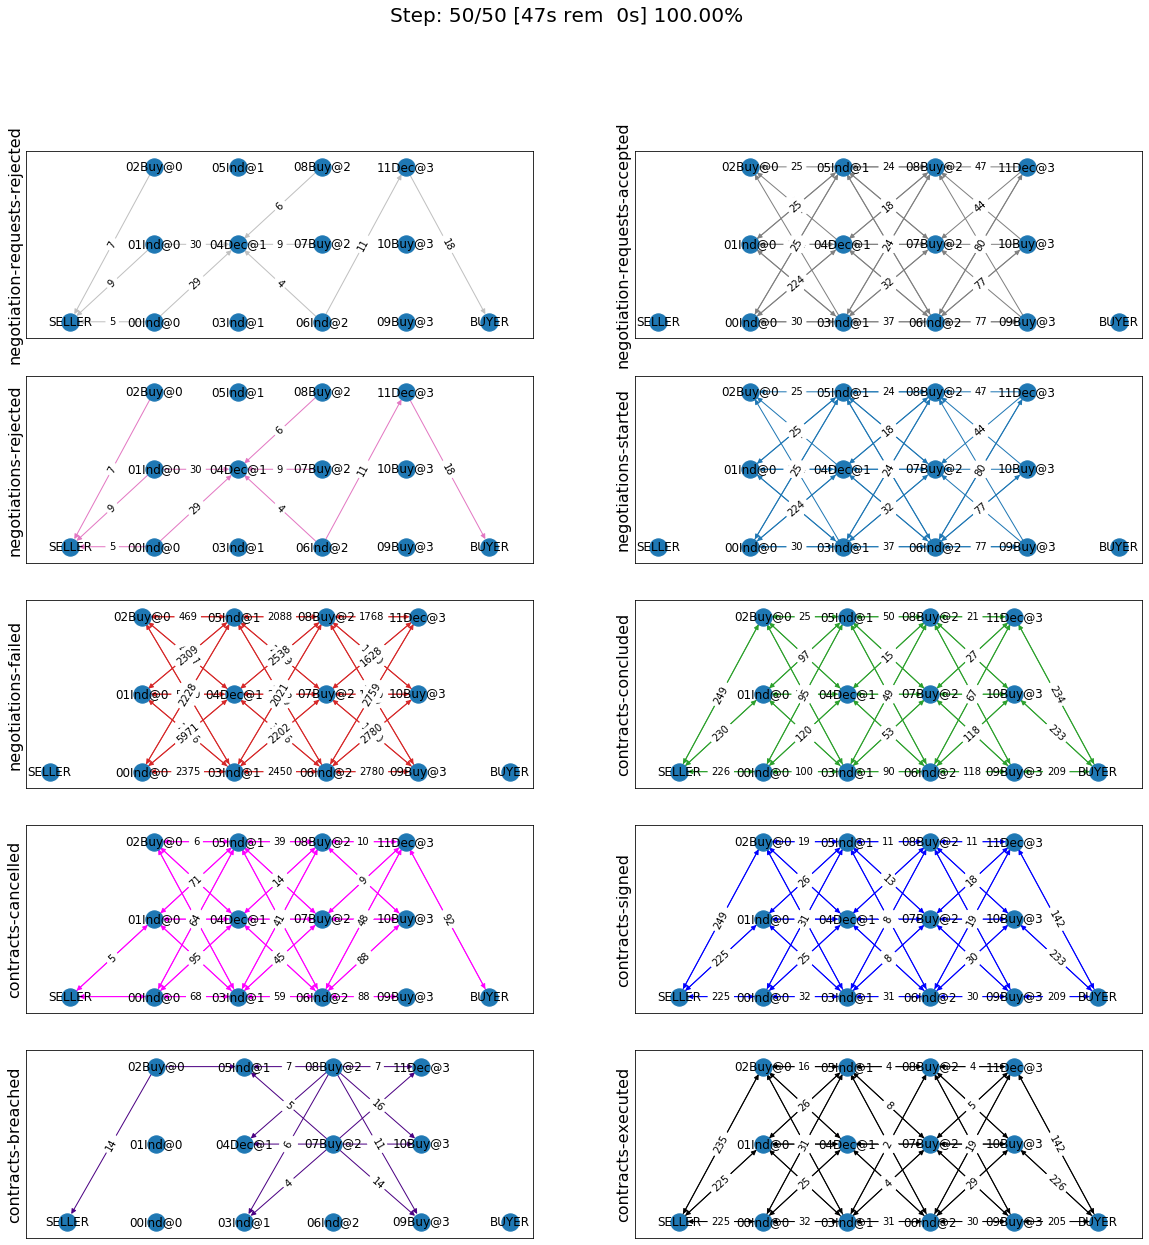

In [34]:
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

You can also run a simple animation to see what happens at every step (you need to download the jupyter notebook and execute it to see the animation) :

In [35]:
# prepare animation
from time import perf_counter
from negmas.helpers import humanize_time
import gif
from pathlib import Path

# define animation parameters
draw_every = 1 # draw every 5 steps (drawing is REALLY slow)
single_graph = False # show a graph for every event type
# what = ["contracts-signed", "contracts-breached", "contracts-executed",]
fps = 5

# define the animation function. Simply draw the world
@gif.frame
def plot_frame(s):
    world.draw(#what=what, 
               steps=(s-draw_every, s), 
               together=single_graph, ncols=3, figsize=(20, 20))
    
# create frames
frames = []
for s in tqdm(range(world.n_steps)):
    if s % draw_every != 0:
        continue
    frames.append(plot_frame(s))

path = Path.cwd() / "run.gif"
path.unlink(missing_ok=True)
gif.save(frames, str(path), duration=1000 // fps)

then show the animation

In [36]:
from IPython.display import HTML
HTML('<img src="run.gif">')

## Running a tournament
    
Now that you can run simple world simulations, let's try to run a complete tournament and see its results.
Let's start by running a standard tournament (in which each agent is represented by a single factory). Running a collusion tournament will be exactly the same with the only difference that `anac2020_std` will be replaced with `anac2020_collusion`.

Note that in the real competition we use thousands of configurations  and longer simulation steps (e.g. 50 $\le$ n_steps $\le$ 500). 

In [37]:
from scml.scml2020.utils import anac2020_std

In [38]:
tournament_types = agent_types + [RandomAgent]
# may take a long time
results = anac2020_std(
    competitors=tournament_types,  
    n_configs=12, # number of different configurations to generate 
    n_runs_per_world=1, # number of times to repeat every simulation (with agent assignment)
    n_steps = 10, # number of days (simulation steps) per simulation
    print_exceptions=True,
) 

Who was the winner?

In [39]:
results.winners

['scml.scml2020.agents.decentralizing.DecentralizingAgent']

How many simulations were actually run?

In [40]:
len(results.scores.run_id.unique())

240

The total number of simulations $n_{s}$ will be $n_t \times n_c \times n_r$ where $n_t$ is the number of competitor agent types, $n_c$ is the number of configurations, and $n_r$ is the number of runs per configuration


We can also see the scores that every agent type got

In [41]:
results.score_stats

,agent_type,count,mean,std,min,25%,50%,75%,max
0,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,192.0,-0.370418,0.408578,-2.323870,-0.417695,-0.262465,-0.164735,0.000000
1,scml.scml2020.agents.decentralizing.Decentrali...,192.0,0.276056,0.230679,-0.207612,0.104886,0.248907,0.403799,1.313861
2,scml.scml2020.agents.decentralizing.IndDecentr...,192.0,0.248426,0.204088,-0.155984,0.086278,0.222172,0.400477,0.833717
3,scml.scml2020.agents.moving.MovingRangeAgent,192.0,-0.043043,0.066882,-0.189195,-0.090739,-0.051096,0.000000,0.169506
4,scml.scml2020.agents.random.RandomAgent,192.0,-0.463315,0.413399,-2.526318,-0.535891,-0.357089,-0.230522,0.000000


You can also do statistical significance testing using ttest or kstest (with multi-comparison correction)

In [42]:
results.kstest

,a,b,t,p,n_a,n_b,n_effective
0,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.decentralizing.IndDecentr...,0.083333,5.186732e-01,192,192,192
1,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.moving.MovingRangeAgent,0.796875,5.102674e-61,192,192,192
2,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,0.927083,1.706484e-89,192,192,192
3,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.random.RandomAgent,0.932292,6.439563e-91,192,192,192
4,scml.scml2020.agents.decentralizing.IndDecentr...,scml.scml2020.agents.moving.MovingRangeAgent,0.770833,1.858813e-56,192,192,192
5,scml.scml2020.agents.decentralizing.IndDecentr...,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,0.890625,2.610863e-80,192,192,192
6,scml.scml2020.agents.decentralizing.IndDecentr...,scml.scml2020.agents.random.RandomAgent,0.937500,2.250385e-92,192,192,192
7,scml.scml2020.agents.moving.MovingRangeAgent,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,0.765625,1.404437e-55,192,192,192
8,scml.scml2020.agents.moving.MovingRangeAgent,scml.scml2020.agents.random.RandomAgent,0.848958,4.208329e-71,192,192,192
9,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,scml.scml2020.agents.random.RandomAgent,0.197917,1.051405e-03,192,192,192


see the total score

In [43]:
results.total_scores

,agent_type,score
0,scml.scml2020.agents.decentralizing.Decentrali...,0.248907
1,scml.scml2020.agents.decentralizing.IndDecentr...,0.222172
2,scml.scml2020.agents.moving.MovingRangeAgent,-0.051096
3,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,-0.262465
4,scml.scml2020.agents.random.RandomAgent,-0.357089


or the aggregated statistics of the world. For example, let's draw the activity level for different simulations.

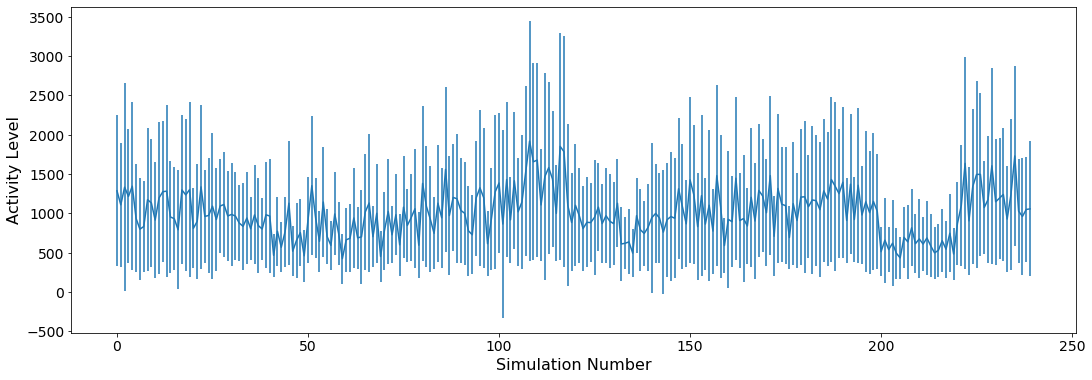

In [44]:
plt.errorbar(range(len(results.agg_stats)),
             results.agg_stats.activity_level_mean, 
             np.sqrt(results.agg_stats.activity_level_var)
             )
plt.xlabel("Simulation Number")
plt.ylabel("Activity Level")
plt.show()

We can even get the scores of every agent belonging to every agent type at every simulation

In [45]:
results.scores.loc[:, ["agent_name", "agent_type", "score"]].head()

,agent_name,agent_type,score
0,00Dec@0,scml.scml2020.agents.decentralizing.Decentrali...,0.322184
1,02Ind@1,scml.scml2020.agents.decentralizing.IndDecentr...,0.415810
2,04Mov@2,scml.scml2020.agents.moving.MovingRangeAgent,-0.067678
3,05Buy@2,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,-0.094984
4,00Buy@0,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,-0.197842


or inspect any statistic we like

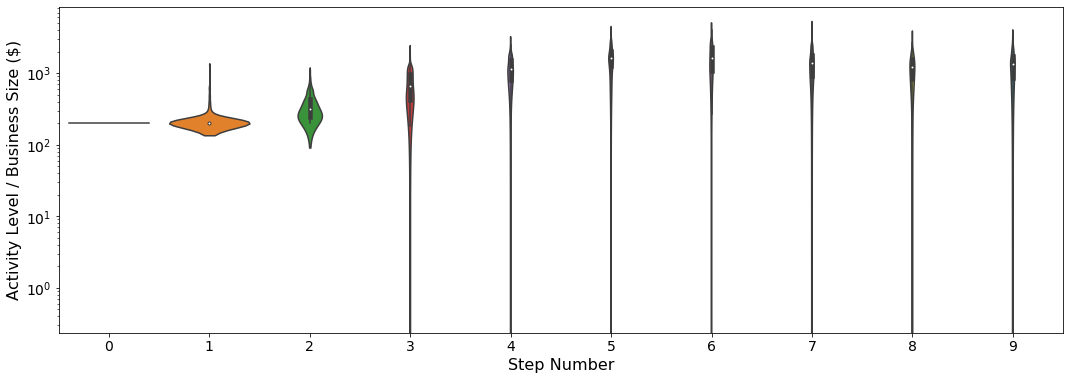

In [46]:
ax = sns.violinplot(data=results.stats, x="step", y="activity_level")
ax.set(ylabel="Activity Level / Business Size ($)", xlabel="Step Number", yscale="log")

plt.gcf().show()

Let's see how did the location at the production graph affect the score of each type.

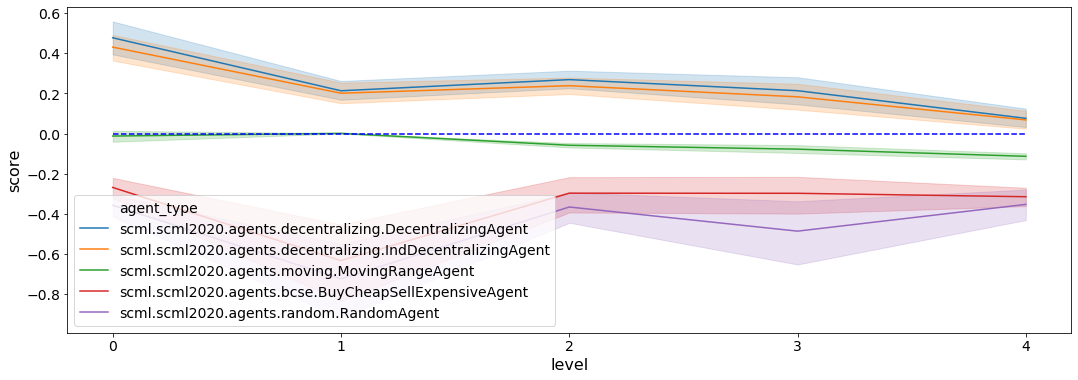

In [47]:
results.scores["level"] = results.scores.agent_name.str.split("@", expand=True).loc[:, 1]
sns.lineplot(data=results.scores[["agent_type", "level", "score"]], 
             x="level", y="score", hue="agent_type")
plt.plot([0.0] * len(results.scores["level"].unique()), "b--")
plt.show()

Now that you can run simulations and complete tournament, let's see how are we going to develop a new agent for the SCML2020 league $\rightarrow$